In [1]:
import cell2cell as c2c

import numpy as np
import pandas as pd

from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data_folder = '../../data/'

In [10]:
import os

output_folder = '../../results/Benchmarking/Classifier-CCI-scores/'
if not os.path.isdir(output_folder):
    os.makedirs(output_folder, exist_ok=True)

# Load Data

In [11]:
dist = pd.read_csv(data_folder + '/Digital-3D-Map/Celegans_Physical_Distances_Min.csv', index_col=0)

In [12]:
counts = pd.read_csv(data_folder + '/Benchmarking/CCI-Matrix-Count-10-TPM.csv', index_col=0)

In [13]:
bray_curtis = pd.read_csv(data_folder + '/Benchmarking/CCI-Matrix-Bray_curtis-10-TPM.csv', index_col=0)

In [14]:
cellchat = pd.read_csv(data_folder + '/Benchmarking/CCI-Matrix-CellChat-weight.csv', index_col=0)
cellchat = cellchat + cellchat.T # Make CCI undirected

In [15]:
icellnet = pd.read_csv(data_folder + '/Benchmarking/CCI-Matrix-ICELLNET.csv', index_col=0)

In [16]:
smillie = pd.read_csv(data_folder + '/Benchmarking/CCI-Matrix-Smillie-10-TPM.csv', index_col=0)

# Preprocessing

In [17]:
pairs = c2c.core.interaction_space.generate_pairs(dist.columns, cci_type='undirected')

In [18]:
len(pairs)

253

In [19]:
cell_int = [p[0] + '; ' + p[1] for p in pairs]

**Distance Matrix**

In [20]:
distances = pd.melt(dist.reset_index(), id_vars='index')
distances.columns = ['Cell1', 'Cell2', 'Distance']

In [21]:
# Exclude autocrine interactions
distances = distances.loc[distances['Distance'] > 0]

In [22]:
def define_range(x):
    if x < 5.6:
        return 'Short-Range Distance'
    elif x < 70.:
        return 'Mid-Range Distance'
    else:
        return 'Long-Range Distance'

In [23]:
distances['Range'] = distances['Distance'].apply(define_range)

In [24]:
distances['Interaction'] = distances.apply(lambda row: row['Cell1'] + '; ' + row['Cell2'], axis=1)

In [25]:
distances = distances.loc[distances['Interaction'].isin(cell_int)].reset_index(drop=True)

In [26]:
distances.head()

,Cell1,Cell2,Distance,Range,Interaction
0,Am/PH_sheath_cells,Touch_receptor_neurons,3.165871,Short-Range Distance,Am/PH_sheath_cells; Touch_receptor_neurons
1,Am/PH_sheath_cells,Oxygen_sensory_neurons,1.809980,Short-Range Distance,Am/PH_sheath_cells; Oxygen_sensory_neurons
2,Touch_receptor_neurons,Oxygen_sensory_neurons,4.874073,Short-Range Distance,Touch_receptor_neurons; Oxygen_sensory_neurons
3,Am/PH_sheath_cells,GABAergic_neurons,2.386306,Short-Range Distance,Am/PH_sheath_cells; GABAergic_neurons
4,Touch_receptor_neurons,GABAergic_neurons,5.458439,Short-Range Distance,Touch_receptor_neurons; GABAergic_neurons


In [27]:
distances.shape

(229, 5)

In [28]:
distances['LR Count'] = [counts.at[row['Cell1'], row['Cell2']] for idx, row in distances.iterrows()]
distances['Bray-Curtis'] = [bray_curtis.at[row['Cell1'], row['Cell2']] for idx, row in distances.iterrows()]
distances['CellChat'] = [cellchat.at[row['Cell1'], row['Cell2']] for idx, row in distances.iterrows()]
distances['ICELLNET'] = [icellnet.at[row['Cell1'], row['Cell2']] for idx, row in distances.iterrows()]
distances['Smillie'] = [smillie.at[row['Cell1'], row['Cell2']] for idx, row in distances.iterrows()]

In [29]:
distances.head()

,Cell1,Cell2,Distance,Range,Interaction,LR Count,Bray-Curtis,CellChat,ICELLNET,Smillie
0,Am/PH_sheath_cells,Touch_receptor_neurons,3.165871,Short-Range Distance,Am/PH_sheath_cells; Touch_receptor_neurons,103.0,0.436441,0.0,5710.643687,0.360763
1,Am/PH_sheath_cells,Oxygen_sensory_neurons,1.809980,Short-Range Distance,Am/PH_sheath_cells; Oxygen_sensory_neurons,123.0,0.502041,0.0,6840.238366,0.604412
2,Touch_receptor_neurons,Oxygen_sensory_neurons,4.874073,Short-Range Distance,Touch_receptor_neurons; Oxygen_sensory_neurons,131.0,0.513725,0.0,7197.693397,0.445390
3,Am/PH_sheath_cells,GABAergic_neurons,2.386306,Short-Range Distance,Am/PH_sheath_cells; GABAergic_neurons,126.0,0.488372,0.0,6744.535180,0.382528
4,Touch_receptor_neurons,GABAergic_neurons,5.458439,Short-Range Distance,Touch_receptor_neurons; GABAergic_neurons,137.0,0.511194,0.0,6883.991032,0.251308


# Analysis

In [30]:
scores = sorted(['LR Count', 'Bray-Curtis', 'CellChat', 'ICELLNET', 'Smillie'])

**Distributions**

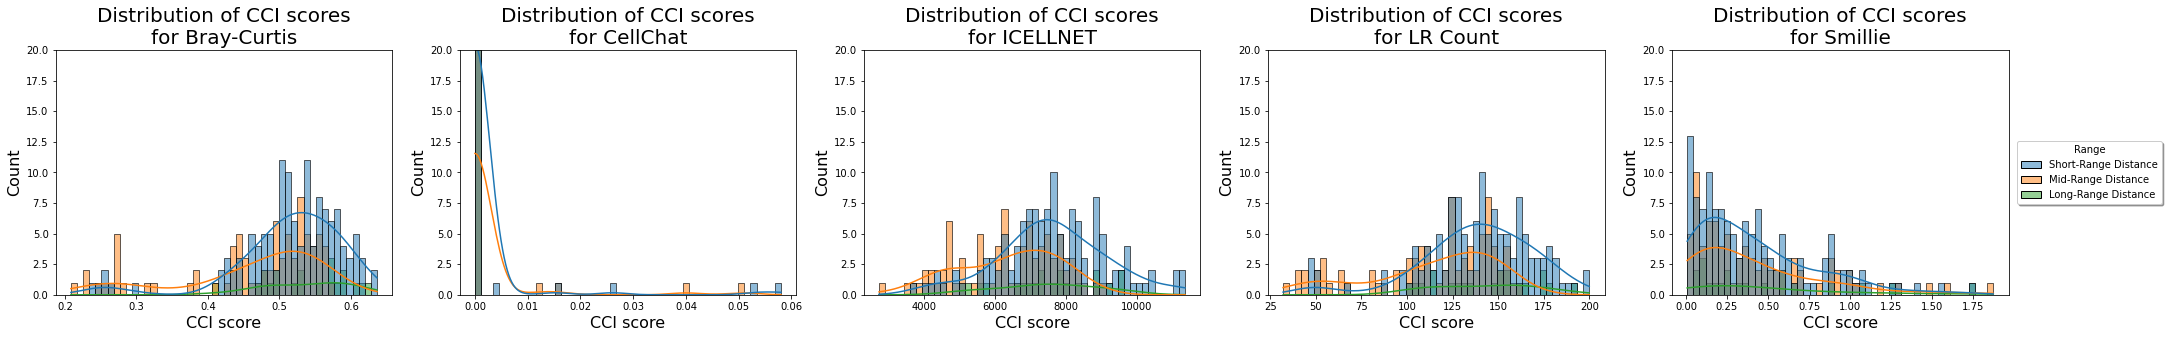

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=len(scores), 
                         figsize=(7*len(scores), 4.5), sharey=False)

flat_axes = axes.flatten()
for i, cci in enumerate(scores):
    ax = flat_axes[i]
    
    sp1 = sns.histplot(data=distances, x=cci, kde=True, hue='Range', bins=50, ax=ax, 
                       legend=True if i == len(scores)-1 else False)
    ax.set_xlabel('CCI score', fontdict={'size' : 16})
    ax.set_ylabel('Count', fontdict={'size' : 16})
    ax.set_title("Distribution of CCI scores\nfor {}".format(cci), fontsize=20)
    
    #ax.set_xlim(0.2, 0.7)
    ax.set_ylim(0, 20.)

sns.move_legend(ax, "center left", bbox_to_anchor=(1.01, 0.5), ncol=1, fancybox=True, shadow=True,)
plt.savefig(output_folder + '/CCI-Distribution-Range.pdf', dpi=300, bbox_inches='tight')

## Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc


from xgboost.sklearn import XGBClassifier

In [33]:
classifier = XGBClassifier(n_estimators=10, n_jobs=10, random_state=0)

In [34]:
kfolds = 3

**Data**

In [35]:
cells = list(dist.columns)

In [36]:
data_input = distances.copy()
for loc in data_input['Range'].unique():
    data_input[loc] = [1 if (l == loc) else 0 for l in data_input['Range']]

In [37]:
lab_mapper = LabelEncoder()
data_input['Range_labels'] = lab_mapper.fit_transform(data_input['Range'])

In [38]:
# Split with Stratified KFold

strat_train_test = dict()

for cci in scores:
    X = data_input[[cci]]
    y = data_input['Range_labels']
    skf = StratifiedKFold(n_splits=kfolds, random_state=0, shuffle=True)
    
    tmp_Xys = []
    for train_idx, test_idx in skf.split(X, y):
        tmp_Xys.append((data_input.iloc[train_idx], data_input.iloc[test_idx]))
    strat_train_test[cci] = tmp_Xys

**Train Classifier**

In [39]:
# Stratified KFold

class_results = defaultdict(lambda: defaultdict(dict))

auc_records = []

for cci in scores:
    for n, v in enumerate(strat_train_test[cci]):
        for class_name in lab_mapper.classes_:
            class_id = lab_mapper.transform([class_name])[0]
            
            X_train, y_train = v[0][[cci]], v[0]['Range_labels']
            X_test, y_test = v[1][[cci]], v[1][class_name]

            class_tmp = classifier.fit(X_train, y_train)
            probas = class_tmp.predict_proba(X_test)
            
            fpr, tpr, thresholds = roc_curve(y_test, probas[:, class_id], pos_label=1)
            roc_auc = auc(fpr, tpr)
            
            class_results[class_name][cci][n] = (fpr, tpr, roc_auc)
            
            auc_records.append((class_name, cci, n, roc_auc))

**Result Analysis**

In [40]:
from scipy import interp

In [41]:
colors = ['#484A47', '#990099', '#e41a1c', '#f7cb15' ,'#c47335']

cmaps = dict(zip(scores, colors))

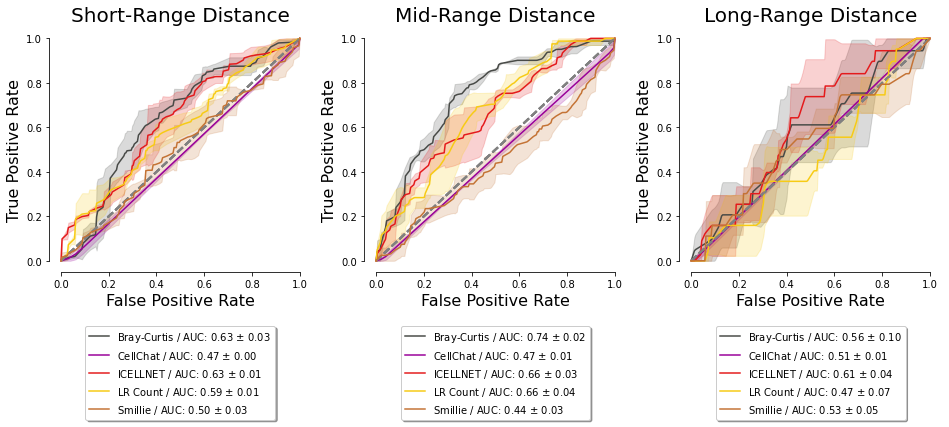

In [42]:
mean_fpr = np.linspace(0, 1, data_input.shape[0])

fig, axes = plt.subplots(nrows=1, ncols=data_input['Range'].unique().shape[0], 
                         figsize=(16, 4.5))

flat_axes = axes.flatten()

for i, class_name in enumerate(sorted(lab_mapper.classes_)[::-1]):
    ax = flat_axes[i]
    for cci in scores:

        tmp_dict = class_results[class_name][cci]
        tpr_ = []
        auc_ = []

        # Interpolate TPRs and get AUCs for each KFold
        for i in range(kfolds):
            tmp_fpr = tmp_dict[i][0]
            tmp_tpr = tmp_dict[i][1]
            tmp_auc = tmp_dict[i][2]

            interpolation = interp(mean_fpr, tmp_fpr, tmp_tpr)
            interpolation[0] = 0.0
            tpr_.append(interpolation)
            auc_.append(tmp_auc)

        # Compute mean and std for TPR and AUC
        mean_tpr = np.mean(tpr_, axis=0)
        std_tpr = np.std(tpr_, axis=0)

        mean_auc = np.mean(auc_)
        std_auc = np.std(auc_)

        # Plot results
        ax.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--") # Diag line
        ax.plot(mean_fpr, mean_tpr, color=cmaps[cci],
                label=r'{} / AUC: {:.2f} $\pm$ {:.2f}'.format(cci, mean_auc, std_auc)
               ) # Label: ROC curve $\pm$ 1 std 
        
        
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper,
                        color=cmaps[cci], 
                        alpha=.2,
                        )
        
        ax.set_xlabel("False Positive Rate", fontdict={'size' : 16})
        ax.set_ylabel("True Positive Rate", fontdict={'size' : 16})
        ax.set_title("{}".format(class_name), fontsize=20)
        
        
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_bounds(0, 1)
        ax.spines['left'].set_bounds(0, 1)
        
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1, fancybox=True, shadow=True,)
        
        
plt.savefig(output_folder + '/CCI-ROC-Curve-Separate-Distances.pdf', dpi=300, bbox_inches='tight')

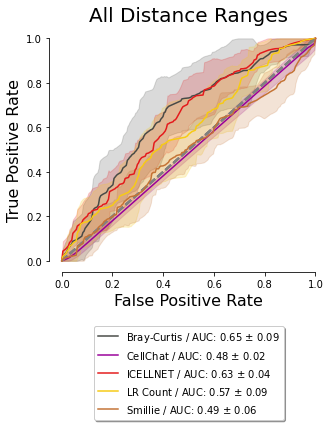

In [43]:
mean_fpr = np.linspace(0, 1, data_input.shape[0])

fig, axes = plt.subplots(nrows=1, ncols=1, 
                         figsize=(5, 4.5))

ax = axes

for cci in scores:
    tpr_ = []
    auc_ = []
    for i, class_name in enumerate(sorted(lab_mapper.classes_)[::-1]):
        tmp_dict = class_results[class_name][cci]
        

        # Interpolate TPRs and get AUCs for each KFold
        for i in range(kfolds):
            tmp_fpr = tmp_dict[i][0]
            tmp_tpr = tmp_dict[i][1]
            tmp_auc = tmp_dict[i][2]

            interpolation = interp(mean_fpr, tmp_fpr, tmp_tpr)
            interpolation[0] = 0.0
            tpr_.append(interpolation)
            auc_.append(tmp_auc)

    # Compute mean and std for TPR and AUC
    mean_tpr = np.mean(tpr_, axis=0)
    std_tpr = np.std(tpr_, axis=0)

    mean_auc = np.mean(auc_)
    std_auc = np.std(auc_)

    # Plot results
    ax.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--") # Diag line
    ax.plot(mean_fpr, mean_tpr, color=cmaps[cci],
            label=r'{} / AUC: {:.2f} $\pm$ {:.2f}'.format(cci, mean_auc, std_auc)
           ) # Label: ROC curve $\pm$ 1 std 


    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper,
                    color=cmaps[cci], 
                    alpha=.2,
                    )

    ax.set_xlabel("False Positive Rate", fontdict={'size' : 16})
    ax.set_ylabel("True Positive Rate", fontdict={'size' : 16})
    ax.set_title("All Distance Ranges", fontsize=20)


    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_bounds(0, 1)
    ax.spines['left'].set_bounds(0, 1)

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1, fancybox=True, shadow=True,)
    
plt.savefig(output_folder + '/CCI-ROC-Curve-All-Distances.pdf', dpi=300, bbox_inches='tight')